In [1]:
import numpy as np
import random
import math
import statistics as stat
import matplotlib
import matplotlib.pyplot as plt
import scipy as scp
import scipy.optimize as sco
import scipy.signal as scs
import scipy.special as ssp
import scipy.integrate as sci
from labellines import labelLines
from itertools import zip_longest, groupby, cycle
from scipy.ndimage import gaussian_filter1d

np_load_old = np.load
np.load = lambda *a,**k: np_load_old(*a, allow_pickle=True, **k)

### Simulation Parameters 

In [2]:
nLat = 8192
nTime = 256
nSims = 20000
lSim = 0
step = 1000
splitdata = np.arange(lSim, nSims+1, step); print('splitdata ', splitdata)

filter_size1 =  50.64719566216843
filter_size2 =  25.323597831084214
filter_size3 =  11.768329733973772

lamb = 1.5; print('lamb = ', lamb)
phi0 = 2*np.pi/6.6; print('phi0 = ', phi0)
nu = 2.*10**(-3)
m2eff = 4. * nu * (- 1. + lamb**2); print('m2eff = ', m2eff)
lenLat = 8 * 0.5 * 50. / np.sqrt(2. * nu); print('lenLat = ', lenLat)
phi_initial = np.pi

nyq = nLat//2+1; spec = nyq//16; dx = lenLat/nLat; dk = 2.*np.pi/lenLat; print('dx, dk, spec ', dx, dk, spec)
alpha = 16.; dt = dx/alpha; dtout = dt*nLat/nTime; print('dtout/dt = ', dtout/dt)
light_cone = int(dtout/dx); print('light_cone = ', light_cone)
tTime = nTime - int(2./np.sqrt(m2eff)/dtout); print('tTime =', tTime)
tcheck = int(1./np.sqrt(m2eff)/dtout); print('tcheck =', tcheck)

splitdata  [    0  1000  2000  3000  4000  5000  6000  7000  8000  9000 10000 11000
 12000 13000 14000 15000 16000 17000 18000 19000 20000]
lamb =  1.5
phi0 =  0.9519977738150889
m2eff =  0.01
lenLat =  3162.2776601683795
dx, dk, spec  0.3860202221885229 0.0019869176531592202 256
dtout/dt =  32.0
light_cone =  2
tTime = 231
tcheck = 12


8.314534070006756
[4.759673735059503, 4.861241173200842, 4.962808611342181]


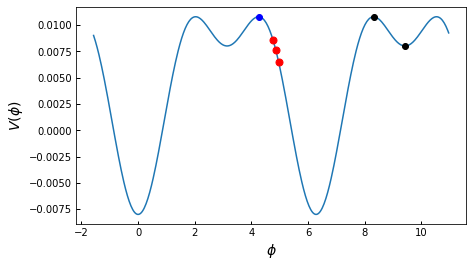

In [3]:
def V(phi, lamb=1.5):
    return ( -np.cos(phi) + 0.5 * lamb**2 * np.sin(phi)**2 ) * 4 * nu
right_phi_at_V_max = sco.minimize_scalar(lambda x: -V(x), bounds=[np.pi, 2*np.pi], method='bounded')
far_right_phi_at_V_max = sco.minimize_scalar(lambda x: -V(x), bounds=[2*np.pi, 3*np.pi], method='bounded'); print(far_right_phi_at_V_max.x)
def F(x):
    return V(x) - V(np.pi)
phi_upper_bound = sco.fsolve(F, 5.5)[0]

list_multiplier, list_threshold= [], []
for multiplier in [0.25, 0.3, 0.35]:
    threshold = right_phi_at_V_max.x + np.abs(right_phi_at_V_max.x-2*phi_initial)*multiplier
    list_multiplier.append(multiplier)
    list_threshold.append(threshold)
print(list_threshold)

fig, ax = plt.subplots(figsize=(7,4))
plt.plot([i for i in np.arange(-np.pi/2, 3.5*phi_initial, phi_initial/100)], [V(i) for i in np.arange(-np.pi/2, 3.5*phi_initial, phi_initial/100)])
[plt.plot(i, V(i), 'ro', ms = 7) for i in list_threshold[:3]]
[plt.plot(i, V(i), 'go', ms = 7) for i in list_threshold[3:]]
ax.tick_params(direction='in', width='1')
plt.plot(3*np.pi, V(3*np.pi), 'ko')
plt.plot(right_phi_at_V_max.x, V(right_phi_at_V_max.x), 'bo')
plt.plot(far_right_phi_at_V_max.x, V(far_right_phi_at_V_max.x), 'ko')
plt.xlabel(r'$\phi$', fontsize=14); plt.ylabel(r'$V(\phi)$', fontsize=14); plt.show()

### Extract data from files

In [4]:
plots_file = '/home/dpirvu/big_plot_file/new_bubble_correlations/'
pickle_file = '/home/dpirvu/pickle_location/new_bubble_correlations/'

def sim_location(sim):
    return '/gpfs/dpirvu/bubble_correlations/t'+str(nTime)+'_x'+str(nLat)+'_len{:.4f}'.format(lenLat)+'_phi0{:.4f}'.format(phi0)+'_lamb{:.4f}'.format(lamb)+'_alph{:.4f}'.format(alpha)+'_spec'+str(spec)+'_sim'+str(sim)+'_fields.dat'
def sim_suffix(phi0, lamb):
    return '_for_phi0{:.4f}'.format(phi0)+'_lamb{:.4f}'.format(lamb)+'_x'+str(nLat)
def pickle_location(phi0, lamb):
    return pickle_file + 'phi0'+str(int(20*np.pi/phi0))+'_lambda'+str(int(10*lamb))+'/'
def pickle_corr_location(phi0, lamb, type):
    return pickle_file + 'th_correlator_type'+type+'_phi0'+str(int(20*np.pi/phi0))+'_lambda'+str(int(10*lamb))
def thrcorr_file(type, threshold, phi0, lamb):
    return pickle_file+'thcorr_type'+str(type)+'_threshold'+str(threshold)+'_for_phi0{:.4f}'.format(phi0)+'_lamb{:.4f}'.format(lamb)+'.npy'

def positive_data_file(phi0, lamb, minSim, maxSim, multiplier, filter):
    pickle = pickle_location(phi0, lamb)
    suffix = sim_suffix(phi0, lamb)
    return pickle+'positive_targets_sims'+str(minSim)+'_to'+str(maxSim-1)+'_multiplier'+str(multiplier)+'_filter{:.4f}'.format(filter)+suffix+'.npy'
def negative_data_file(phi0, lamb, minSim, maxSim, multiplier, filter):
    pickle = pickle_location(phi0, lamb)
    suffix = sim_suffix(phi0, lamb)
    return pickle+'negative_targets_sims'+str(minSim)+'_to'+str(maxSim-1)+'_multiplier'+str(multiplier)+'_filter{:.4f}'.format(filter)+suffix+'.npy'

def import_all_data(lamb, phi0, multiplier, filter):
    postlist, negtlist = [], []
    for minSim, maxSim in zip(splitdata, splitdata[1:]):
        postlist.append(np.load(positive_data_file(phi0, lamb, minSim, maxSim, multiplier, filter)))
        negtlist.append(np.load(negative_data_file(phi0, lamb, minSim, maxSim, multiplier, filter)))
    positive_targets = np.concatenate(tuple(postlist)).tolist()
    negative_targets = np.concatenate(tuple(negtlist)).tolist()
    return positive_targets, negative_targets

In [5]:
def extract_slice(sim, timeslice, filter):
    slice = np.reshape(np.genfromtxt(sim_location(sim)), (nTime, nLat))[timeslice] - phi_initial
    return gaussian_filter1d(slice, sigma=filter, mode='wrap')

def extract_sim(sim, filter):
    data = np.reshape(np.genfromtxt(sim_location(sim)), (nTime, nLat))
    return np.asarray([gaussian_filter1d(i, sigma=filter, mode='wrap') for i in data])

def select(sim_selection, timeslice, lamb, phi0, multiplier, filter):
    bad_sims = []
    positiveBubbles, negativeBubbles = import_all_data(lamb, phi0, multiplier, filter) #taking only +ve bubbles
    for sim in sim_selection:
        bub_coords = positiveBubbles[sim] + negativeBubbles[sim]
        if any(bubb[0] < timeslice for bubb in bub_coords):
            bad_sims.append(sim)
        else:
            slice = extract_slice(sim, ig, filter)
            tv = count_peaks(slice, right_phi_at_V_max.x-np.pi)
            tv += count_peaks(-slice, right_phi_at_V_max.x-np.pi)
            if tv > 0:
                bad_sims.append(sim)
    good_sims = [sim for sim in sim_selection if sim not in bad_sims]
    return [positiveBubbles[sim] for sim in good_sims], good_sims

def analytic_peak_number_density(thr, phi0, lamb, filter):
    """ thr is field amplitude from mean"""
    if filter == filter_size3:
        if lamb == 1.5:
            if phi0 == 2*np.pi/6.6:
                return 0.0183654 + np.exp(-4.32048*thr**2)*(0.00972754 + 0.00972754*ssp.erf(1.29798*thr)) - 0.0183654 * ssp.erf(2.45056*thr)
            elif phi0 == 2*np.pi/7.:
                return 0.0183654 + np.exp(-3.84082*thr**2)*(0.00972754 + 0.00972754*ssp.erf(1.22381*thr)) - 0.0183654 * ssp.erf(2.31052*thr)
        elif lamb == 1.6:
            return 0.0184917 + np.exp(-4.63026*thr**2)*(0.00991804 + 0.00991804*ssp.erf(1.36745*thr)) - 0.0184917 * ssp.erf(2.54954*thr)
    elif filter == filter_size1:
        if lamb == 1.5:
            if phi0 == 2*np.pi/6.6:
                return 0.00478467 + np.exp(-13.5697*thr**2)*(0.00277661 + 0.00277661*ssp.erf(2.62491*thr)) - 0.00478467 * ssp.erf(4.52326*thr)
            elif phi0 == 2*np.pi/7.:
                return 0.00478467 + np.exp(-12.0632*thr**2)*(0.00277661 + 0.00277661*ssp.erf(2.47491*thr)) - 0.00478467 * ssp.erf(4.26478*thr)
        elif lamb == 1.6:
            return 0.00481253 + 0.00279733 * np.exp(-15.016*thr**2) + 0.00279733*np.exp(-15.016*thr**2) * ssp.erf(2.76804*thr) - 0.00481253 * ssp.erf(4.76214*thr)
    elif filter == filter_size2:
        if lamb == 1.5:
            if phi0 == 2*np.pi/6.6:
                return 0.00913243 + 0.00513977 * np.exp(-7.43489*thr**2) + 0.00513977*np.exp(-7.43489*thr**2)*ssp.erf(1.85654*thr) - 0.00913243*ssp.erf(3.29873*thr)
            elif phi0 == 2*np.pi/7.:
                return 0.00913243 + np.exp(-6.60947*thr**2)*(0.00513977 + 0.00513977*ssp.erf(1.75045*thr)) - 0.00289268*ssp.erf(3.11023*thr)-0.00623974*ssp.erf(3.11023*thr)
        elif lamb == 1.6:
            return 0.00920829 + np.exp(-8.12031*thr**2)*(0.00521375 + 0.00521375 *ssp.erf(1.95745*thr)) - 0.00920829*ssp.erf(3.45715*thr)

def count_peaks(slice, threshold):
    """ Finds x coordinate of peaks in masked field with mask applied at threshold. """
    peak_coord = scs.find_peaks(slice, height = threshold)[0].tolist()
    if slice[-1] >= threshold and slice[0] >= threshold and slice[-1] != slice[0]:
        if slice[0] > slice[-1] and slice[0] > slice[1]:
            peak_coord.append(0)
        elif slice[0] < slice[-1] and slice[-1] > slice[-2]:
            peak_coord.append(len(slice)-1) # this minds potential boundary discontinuities
    return len(peak_coord)

def round_to_n(x, n):
    return x if x == 0 else round(x, -int(math.floor(math.log10(abs(x)))) + (n - 1))

In [6]:
maxthr = 1.5*np.pi
thrcoarse = np.linspace(0, maxthr, 1000)
thrfine = np.linspace(0, maxthr, 1000)
smoothing = filter_size3
ig = 2*tcheck

an_peak_numdens = [analytic_peak_number_density(th, phi0, lamb, smoothing) for th in thrfine]

every_sim = np.arange(nSims)
time_list = [int(i) for i in np.linspace(2, 70, 10)]; print(time_list)
precision = 2
multiplier = 0.25 #in [0.25, 0.3, 0.35]

[2, 9, 17, 24, 32, 39, 47, 54, 62, 70]


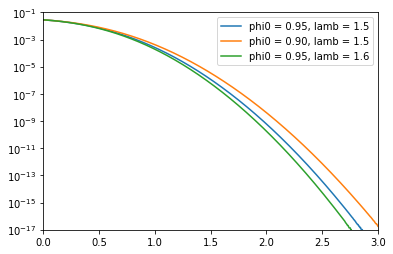

In [7]:
plt.semilogy(thrfine, [analytic_peak_number_density(thr, 2*np.pi/6.6, 1.5, smoothing) for thr in thrfine], label='phi0 = {:.2f}'.format(2*np.pi/6.6)+', lamb = {:.1f}'.format(1.5))
plt.semilogy(thrfine, [analytic_peak_number_density(thr, 2*np.pi/7., 1.5, smoothing) for thr in thrfine], label='phi0 = {:.2f}'.format(2*np.pi/7.)+', lamb = {:.1f}'.format(1.5))
plt.semilogy(thrfine, [analytic_peak_number_density(thr, 2*np.pi/6.6, 1.6, smoothing) for thr in thrfine], label='phi0 = {:.2f}'.format(2*np.pi/6.6)+', lamb = {:.1f}'.format(1.6))
plt.xlim((0,3))
plt.ylim((1e-17,1e-1))
plt.legend(); plt.show()

In [8]:
# bubble number density at initialisation (no bubbles there):
slices = [extract_slice(sim, 0, smoothing) for sim in range(lSim, nSims, int(nSims//10))]
in_peak_nd = np.asarray([np.nanmean([count_peaks(slice, th)/lenLat for slice in slices]) for th in thrcoarse])

(3.0, 5.0)

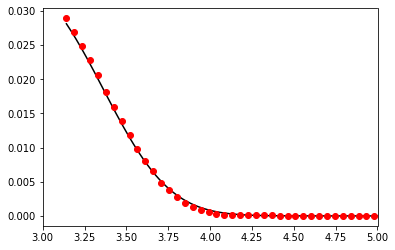

In [9]:
plt.plot(thrfine+phi_initial, an_peak_numdens, 'k-', thrcoarse[::10]+phi_initial, in_peak_nd[::10], 'ro')
plt.xlim((3, 5))

In [10]:
if False:
    validsims, nvalidsims, bubble_numdens, peak_numdens, matching_numdens, matching_threshold_value, TIME = [], [], [], [], [], [], []
    for timeslice in time_list:
        # check if there are any bubbles at t = timeslice and discard if yes; import coordinates of nucleation sites for threshold = multiplier
        valid_bubble_data, every_sim = select(every_sim, timeslice, lamb, phi0, multiplier, smoothing)
        validsims.append(every_sim)
        nvalidsims.append(len(every_sim))

        if nvalidsims[-1] > 0:
            TIME.append(timeslice)
            # import smoothed field slices for only good sims
            valid_slices = [extract_slice(sim, timeslice+ig, smoothing) for sim in validsims[-1]]
            # get peak number densities (for each thr) in those sims at t = timeslice
            peak_numdens.append([np.nanmean([count_peaks(slice, th)/lenLat for slice in valid_slices]) for th in thrcoarse])

            # bubble number density (one, overall) at t = timeslice rounded to # significant digits
            bubble_numdens.append(np.nanmean([len([bbc for bbc in bubbles_in_sim if bbc[0] == timeslice+ig])/lenLat for bubbles_in_sim in valid_bubble_data]))

            # for the peak number density (at each thr in thrcoarse), find where we get a match with the number density of bubbles (at t = timeslice)
            matching_thr, matching_nd = [], []
            for coord, pknd in enumerate(peak_numdens[-1]):
                if round_to_n(pknd, precision) == round_to_n(bubble_numdens[-1],precision):
                    matching_thr.append(thrcoarse[coord])
                    matching_nd.append(pknd)
            matching_threshold_value.append(np.nanmean(matching_thr))
            matching_numdens.append(np.nanmean(matching_nd))

            print('Done')

In [13]:
savefile = pickle_location(phi0, lamb) + 'decay_data.npy'
#savedata = in_peak_nd, validsims, nvalidsims, bubble_numdens, peak_numdens, matching_numdens, matching_threshold_value, TIME
#np.save(savefile, savedata)

In [14]:
savedata = np.load(savefile)
in_peak_nd, validsims, nvalidsims, bubble_numdens, peak_numdens, matching_numdens, matching_threshold_value, TIME = savedata

In [24]:
def log_plot_peak_number_density(matching_numdens, matching_threshold_value, peak_numdens):
    col = cycle(('red', 'orange', 'gold', 'lawngreen', 'lightseagreen', 'royalblue', 'blueviolet', 'indigo'))
    fig, ax = plt.subplots(figsize=(10,5))
    ax.semilogy(thrfine+phi_initial, np.asarray(an_peak_numdens), color='k', ls='-', linewidth=2, label='Free field') #semilogy
    color = next(col)
    ax.plot(thrcoarse+phi_initial, in_peak_nd, color=color, ls='', marker='o', ms=3, label='t = '+str(0))
    for timeslice in range(len(TIME)):
        color = next(col)
        ax.plot(thrcoarse+phi_initial, peak_numdens[timeslice], color=color, ls='', marker='o', ms=3, label='t = '+str(TIME[timeslice]+ig))
#        ax.plot(matching_threshold_value[timeslice]+phi_initial, matching_numdens[timeslice], color=color, marker='*', ms=20)
    plt.xlim((phi_initial, 2*phi_initial))
    plt.ylim((1e-6, 5e-2))
    plt.xlabel(r'$\phi_t$'); plt.ylabel(r'Peak Number Density $n(\nu_t)$')
    plt.grid(); plt.legend(); plt.savefig(plots_file+'peak_ndens_th_vs_data.png'); plt.show()
    return

def plot_peak_number_density(matching_numdens, matching_threshold_value, peak_numdens):
    col = cycle(('red', 'orange', 'gold', 'lawngreen', 'lightseagreen', 'royalblue', 'blueviolet', 'indigo'))
    fig, ax = plt.subplots(figsize=(10,5))
    ax.plot(thrfine+phi_initial, np.asarray(an_peak_numdens), color='k', ls='-', linewidth=2, label='Free field') #semilogy
    color = next(col)
    ax.plot(thrcoarse+phi_initial, in_peak_nd, color=color, ls='', marker='o', ms=3, label='t = '+str(0))
    for timeslice in range(len(TIME)):
        color = next(col)
        ax.plot(thrcoarse+phi_initial, peak_numdens[timeslice], color=color, ls='', marker='o', ms=3, label='t = '+str(TIME[timeslice]+ig))
#        ax.plot(matching_threshold_value[timeslice]+phi_initial, matching_numdens[timeslice], color=color, marker='*', ms=20)
    plt.xlim((phi_initial, 1.5*phi_initial))
    plt.xlabel(r'$\phi_t$'); plt.ylabel(r'Peak Number Density $n(\nu_t)$')
    plt.grid(); plt.legend(); plt.savefig(plots_file+'peak_ndens_th_vs_data.png'); plt.show()
    return

def plot_potential(matching_threshold_value):
    fig = plt.figure(figsize=(7, 4))
    plt.plot([i for i in np.arange(phi_initial, 4*phi_initial, phi_initial/100)], [V(i) for i in np.arange(phi_initial, 4*phi_initial, phi_initial/100)])
    [plt.plot(right_phi_at_V_max.x + np.abs(right_phi_at_V_max.x-phi_upper_bound)*m, V(right_phi_at_V_max.x + np.abs(right_phi_at_V_max.x-phi_upper_bound)*m), marker='o', ms=7) for m in [0.75, 1, 1.25]]
    val = np.nanmean(matching_threshold_value) + phi_initial
    print('send to notebook:', val)
#    for val in matching_numdens:
    plt.plot(val, V(val), marker='*', ms=15, label=round_to_n(val, 3))
    plt.xlabel(r'$\phi(x)$')
    plt.ylabel(r'$V(\phi(x))$')
    plt.legend()
    plt.savefig(plots_file+'potential_threshold.png')
    plt.show()
    return

def plot_decayrate(surv):
    surv = surv[:len(TIME):]
    fig = plt.figure(figsize=(7, 4))
    val = np.mean(surv)
    plt.plot(TIME, np.asarray(surv)/surv[0])
    plt.xlabel(r't')
    plt.ylabel(r'F surviving sims')
    plt.savefig(plots_file+'decay_rate.png')
    plt.show()
    return

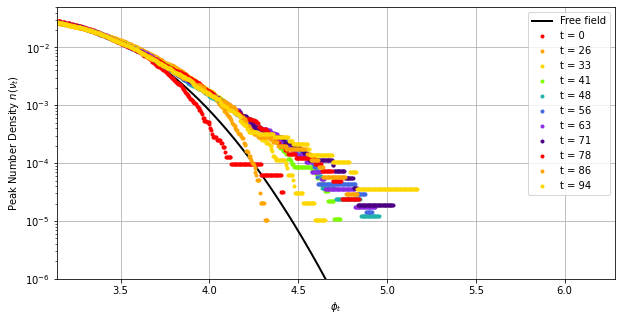

In [25]:
log_plot_peak_number_density(matching_numdens, matching_threshold_value, peak_numdens)

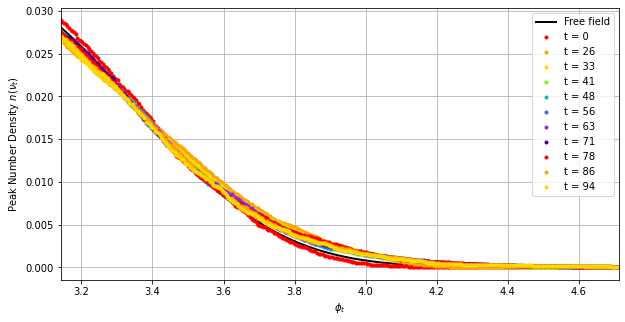

In [26]:
plot_peak_number_density(matching_numdens, matching_threshold_value, peak_numdens)

In [27]:
bubble_numdens

[0.0, 0.0, 0.0, 2.4e-05, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

In [21]:
round_to_n(np.nanmean(bubble_numdens), precision)

8e-05

In [22]:
np.asarray([round_to_n(i, precision) for i in an_peak_numdens if 1e-8 < i < 1e-4])

array([9.6e-05, 9.2e-05, 8.8e-05, 8.4e-05, 8.0e-05, 7.7e-05, 7.3e-05,
       7.0e-05, 6.7e-05, 6.4e-05, 6.1e-05, 5.8e-05, 5.5e-05, 5.3e-05,
       5.0e-05, 4.8e-05, 4.6e-05, 4.3e-05, 4.1e-05, 3.9e-05, 3.8e-05,
       3.6e-05, 3.4e-05, 3.2e-05, 3.1e-05, 2.9e-05, 2.8e-05, 2.7e-05,
       2.5e-05, 2.4e-05, 2.3e-05, 2.2e-05, 2.1e-05, 2.0e-05, 1.9e-05,
       1.8e-05, 1.7e-05, 1.6e-05, 1.5e-05, 1.4e-05, 1.4e-05, 1.3e-05,
       1.2e-05, 1.2e-05, 1.1e-05, 1.0e-05, 9.8e-06, 9.3e-06, 8.8e-06,
       8.4e-06, 7.9e-06, 7.5e-06, 7.1e-06, 6.7e-06, 6.3e-06, 6.0e-06,
       5.7e-06, 5.4e-06, 5.1e-06, 4.8e-06, 4.5e-06, 4.3e-06, 4.0e-06,
       3.8e-06, 3.6e-06, 3.4e-06, 3.2e-06, 3.0e-06, 2.9e-06, 2.7e-06,
       2.5e-06, 2.4e-06, 2.3e-06, 2.1e-06, 2.0e-06, 1.9e-06, 1.8e-06,
       1.7e-06, 1.6e-06, 1.5e-06, 1.4e-06, 1.3e-06, 1.2e-06, 1.2e-06,
       1.1e-06, 1.0e-06, 9.7e-07, 9.1e-07, 8.6e-07, 8.1e-07, 7.6e-07,
       7.1e-07, 6.7e-07, 6.3e-07, 5.9e-07, 5.5e-07, 5.2e-07, 4.9e-07,
       4.6e-07, 4.3e

send to notebook: 4.2689810082564


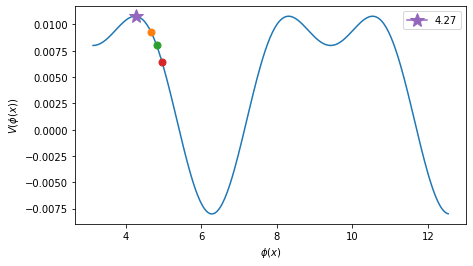

[None]

In [25]:
qwe = [an_peak_numdens.index(i) for i in an_peak_numdens if round_to_n(i, precision) == round_to_n(np.nanmean(bubble_numdens), precision)]
[plot_potential(thrfine[i]) for i in qwe]

send to notebook: 4.714747533427925


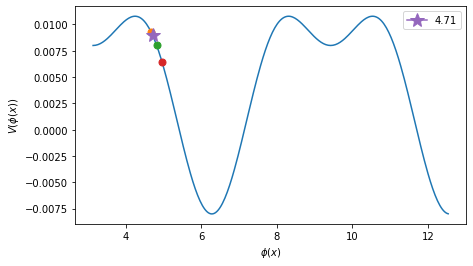

In [26]:
plot_potential(matching_thr)

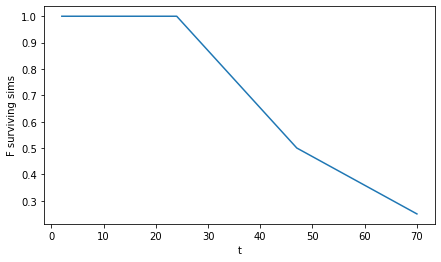

In [27]:
plot_decayrate(nvalidsims)

In [35]:
bubble_data, _ = import_all_data(lamb, phi0, multiplier, smoothing) #taking only +ve bubbles

timeslice = TIME[1]
print(timeslice)
for sim in validsims[TIME.index(timeslice)]:
    bb_coords = bubble_data[sim]
    cds = [bb_coords[i][1] for i in range(len(bb_coords)) if bb_coords[i][0] == timeslice]
    if len(cds) != 0:
        slice = extract_slice(sim, timeslice+ig, filter)
        print(sim, cds, count_peaks(slice, 4.5))

        plt.figure()
        plt.plot(slice)
        plt.plot(cds, [i for i in range(len(cds))], 'o')
        plt.show()
        
        fig, ax = plt.subplots(1, 1, figsize = (20, 4))
        im0 = ax.imshow(extract_sim(sim), aspect='auto', interpolation='none', origin='lower')
        clb = plt.colorbar(im0, ax = ax)
        plt.show()

24
